In [ ]:
# Set working directory (optional during development)
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics




# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_prophet import (
    prepare_prophet_data,
    train_baseline_prophet,
    forecast_with_model,
    calculate_peak_hours,
    evaluate_metrics,
    cross_validate_baseline
)



In [45]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [46]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for Prophet
restaurant_train_prophet, restaurant_test_prophet = prepare_prophet_data(restaurant_train, restaurant_test)
# Train the baseline Prophet model
m = train_baseline_prophet(restaurant_train_prophet)

In [47]:
# -- Test Set Forecasting --
# Predict on the test set and display the first few rows
test_forecast_df = forecast_with_model(m, restaurant_test_prophet)
print("Forecast on Test Set (first 5 rows):")
print(test_forecast_df.head())


Forecast on Test Set (first 5 rows):
                   ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2022-01-01 00:00:00  20.446485   -1.052530   17.732909    20.446485   
1 2022-01-01 01:00:00  20.446561    0.599056   20.569476    20.446561   
2 2022-01-01 02:00:00  20.446637    1.806526   22.069399    20.446637   
3 2022-01-01 03:00:00  20.446713    0.939276   20.428137    20.446713   
4 2022-01-01 04:00:00  20.446789   -0.871659   18.431728    20.446789   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    20.446485      -11.624321            -11.624321            -11.624321   
1    20.446561       -9.794884             -9.794884             -9.794884   
2    20.446637       -8.705095             -8.705095             -8.705095   
3    20.446713      -10.132657            -10.132657            -10.132657   
4    20.446789      -11.764320            -11.764320            -11.764320   

       daily  daily_lower  daily_upper    weekly  weekl

In [49]:
# Calculate average forecast per hour
hourly_avg = test_forecast_df.groupby('Hour')['yhat'].mean()
print("\nAverage Forecast by Hour:")
display(hourly_avg)


Average Forecast by Hour:


Hour
0      7.246245
1      9.169158
2     10.371492
3      9.074454
4      7.590038
5      8.459568
6     11.104544
7     12.760900
8     12.392444
9     12.769541
10    17.787457
11    27.462583
12    36.149942
13    36.782499
14    27.776974
15    15.894710
16    11.539598
17    20.027610
18    36.537792
19    49.516678
20    49.785918
21    37.493399
22    21.121063
23     9.987529
Name: yhat, dtype: float64

In [50]:
peak_hours_dynamic, hourly_avg, threshold = calculate_peak_hours(test_forecast_df)

print("\nThreshold for Peak Hours:", threshold)
print("\nDynamically Identified Peak Hours:", peak_hours_dynamic)

# Filter forecast and actuals for dynamically identified peak hours
forecast_peak_df = test_forecast_df[test_forecast_df['Hour'].isin(peak_hours_dynamic)]
actual_peak_df = restaurant_test_prophet[restaurant_test_prophet['Hour'].isin(peak_hours_dynamic)]


Threshold for Peak Hours: 29.87155088616458

Dynamically Identified Peak Hours: [12, 13, 18, 19, 20, 21]


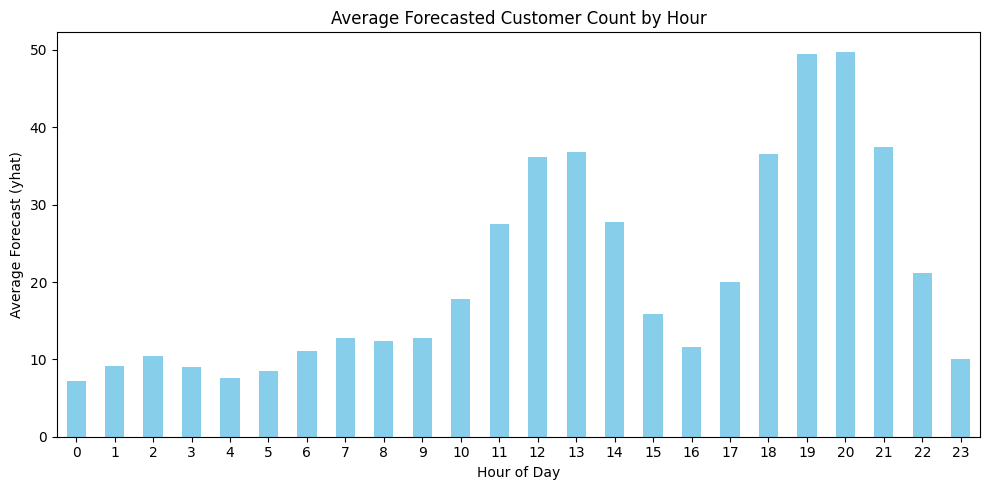

In [ ]:
# ----- Average forecasted customer count by hour -----
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar', color='skyblue')
plt.title("Average Forecasted Customer Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Forecast (yhat)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

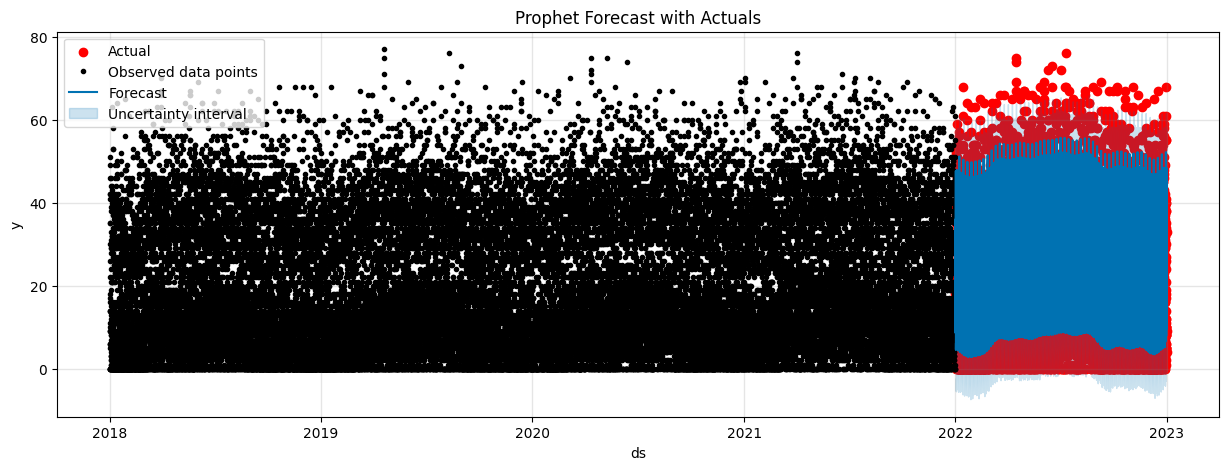

In [52]:
# ----- Compare Forecast to Actuals (All Hours) -----
# Plot the forecast with the actual test values
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
ax.set_title("Prophet Forecast with Actuals")
ax.legend()
plt.show()

In [ ]:
# ----- Zoom In: January 2022 (All Hours) -----
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2022-01-01'), upper=pd.to_datetime('2022-02-01'))
ax.set_ylim(0, 80)
plt.suptitle('January 2022 Forecast vs Actuals')
ax.legend()
plt.show()

# ----- Zoom In Further: First Week of January 2022 (All Hours) -----
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
lower_bound = pd.to_datetime('2022-01-01')
upper_bound = pd.to_datetime('2022-01-08')
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 80)
ax.set_title('First Week of January 2022 Forecast vs Actuals')
ax.legend()
plt.show()